# Wine Quality Dataset - Precise GP

In [1]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from src.utils import create_dataset
import seaborn as sns
import torch
from tensorflow.python.ops.numpy_ops import np_config
from src.models.validation import measure_mnll, measure_rmse, kfold_cv_model
from src.models.kernels import LambdaRBF, ARD_gpflow
from src.models.models import GPRLasso, SVGPLasso
from sklearn.model_selection import KFold
from src.utils import create_dataset, plot_matrix, plot_matrix_cv
np_config.enable_numpy_behavior()
#plt.rcParams["figure.figsize"] = (8, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 
tf.random.set_seed(42)
np.random.seed(42)

2023-05-04 11:15:31.049284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


## Import the Wine Dataset

In [2]:
def csv_to_pth(name, csv_path, pth_path):
    def dataframe_to_arrays(df):
        df_ = df.copy(deep=True)
        X = np.atleast_2d(df_[input_cols].to_numpy())
        Y = np.atleast_2d(df_[output_cols].to_numpy().reshape(-1,1))
        return X, Y
    dataframe_raw = pd.read_csv(csv_path, delimiter=';')
    dataframe_raw.head()
    input_cols = list(dataframe_raw.columns)[:-1]
    output_cols = list(dataframe_raw.columns)[-1]
    X, Y = dataframe_to_arrays(dataframe_raw)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    inputs = torch.tensor(X, dtype=torch.float64)
    targets = torch.tensor(Y, dtype=torch.float64)
    torch.save([inputs, targets], pth_path + name + '.pth')
    return input_cols, output_cols
input_cols, output_cols = csv_to_pth("wine", "data/winequality-red.csv", "data/")

In [3]:
X, Y = create_dataset('wine', 42, False)
Y_mean, Y_std = Y.mean(0), Y.std(0) + 1e-9
Y = (Y - Y_mean) / Y_std
D = X.shape[1]

name,class,transform,prior,trainable,shape,dtype,value
SVGPLasso.kernel.L,Parameter,Identity,,True,"(66,)",float64,"[0.30151, 0., 0...."
SVGPLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGPLasso.inducing_variable.Z,Parameter,Identity,,True,"(100, 11)",float64,"[[-0.52836, 0.96188, -1.39147..."
SVGPLasso.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[0....
SVGPLasso.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."


ADAM started...
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
ADAM finished


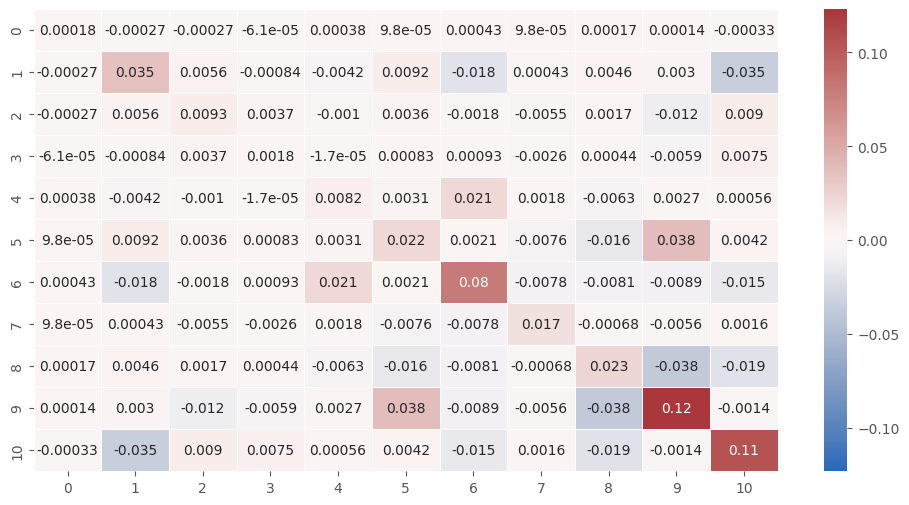

In [4]:
LRBF = LambdaRBF(variance=1.0, randomized=False, d=D)
model_params = {'num_inducing': 100, 'likelihood': gpflow.likelihoods.Gaussian(), 'max_iter': 10000, 'minibatch_size': 100, 'lasso': 10, 'tol_sparsity': 0.1}
svgp_lasso_LRBF = gp_model = SVGPLasso(data=(X, Y), kernel=LRBF, lasso=model_params['lasso'], num_inducing=model_params['num_inducing'], likelihood=model_params['likelihood'], max_iter=model_params['max_iter'], minibatch_size=model_params['minibatch_size'])
gpflow.utilities.print_summary(svgp_lasso_LRBF, fmt="notebook")
svgp_lasso_LRBF.train()
plot_matrix(svgp_lasso_LRBF.kernel.precision())

In [8]:
kfolds = KFold(n_splits = 5, shuffle=True, random_state=0)
model_params = {'num_inducing': 100, 'likelihood': gpflow.likelihoods.Gaussian(), 'max_iter': 10000, 'minibatch_size': 100, 'lasso': 10, 'tol_sparsity': 0.1}
results_GPR_RBF_ARD = kfold_cv_model(model='SVGP-Lasso', X=X, Y=Y, kernel='RBF-ARD', k_folds=kfolds, model_params=model_params, iprint=True)

-- Model: SVGP-Lasso; Kernel: RBF-ARD; --
KFold - fold 0
ADAM started...
ADAM finished
KFold - fold 1
ADAM started...
ADAM finished
KFold - fold 2
ADAM started...
ADAM finished
KFold - fold 3
ADAM started...
ADAM finished
KFold - fold 4
ADAM started...
ADAM finished
Average test RMSE: 0.792
Average test MNLL: 34.225



In [10]:
kfolds = KFold(n_splits = 5, shuffle=True, random_state=0)
model_params = {'num_inducing': 100, 'likelihood': gpflow.likelihoods.Gaussian(), 'max_iter': 10000, 'minibatch_size': 100, 'lasso': 10, 'tol_sparsity': 0.1}
results_GPR_LRBF = kfold_cv_model(model='SVGP-Lasso', X=X, Y=Y, kernel='LRBF', k_folds=kfolds, model_params=model_params, iprint=True)

-- Model: SVGP-Lasso; Kernel: LRBF; --
KFold - fold 0
ADAM started...
ADAM finished
KFold - fold 1
ADAM started...
ADAM finished
KFold - fold 2
ADAM started...
ADAM finished
KFold - fold 3
ADAM started...
ADAM finished
KFold - fold 4
ADAM started...
ADAM finished
Average test RMSE: 0.791
Average test MNLL: 40.820



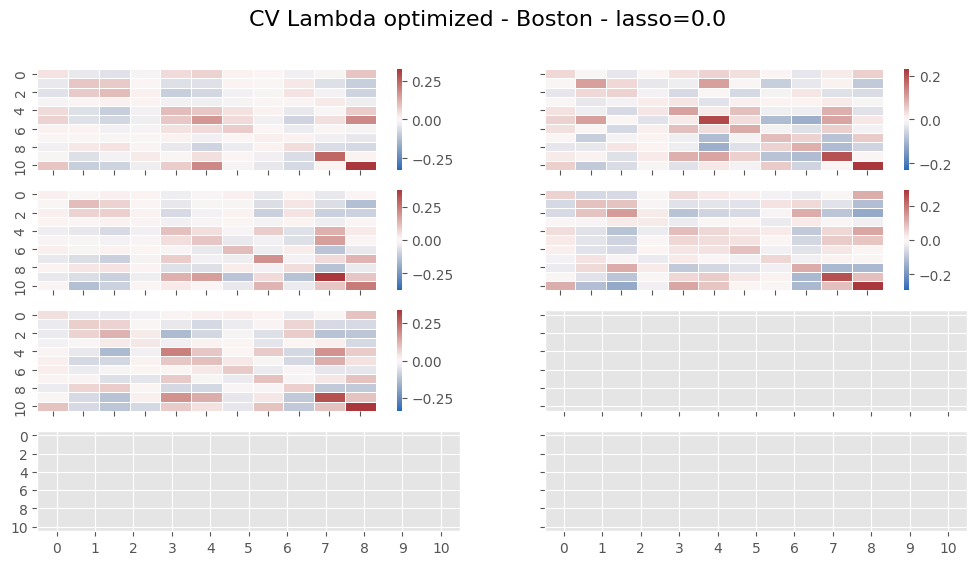

In [7]:
plot_matrix_cv(results_GPR_LRBF['Lambda'], info={'dataset':'Boston', 'lasso':0})